In [5]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit

Globbing and reading in all the data:

In [16]:
flat1 = fits.getdata('/Users/anikaslizewski/Lab-Journal/ccddata/295flats/flat29_5(2).FIT').astype(np.int32)
flat2 = fits.getdata('/Users/anikaslizewski/Lab-Journal/ccddata/295flats/flat29_5(3).FIT').astype(np.int32)
bias1 = fits.getdata('/Users/anikaslizewski/Lab-Journal/ccddata/bias1.FIT').astype(np.int32)
bias2 = fits.getdata('/Users/anikaslizewski/Lab-Journal/ccddata/bias2.FIT').astype(np.int32) 
flat_list = glob.glob('/Users/anikaslizewski/Lab-Journal/ccddata/flat***.FIT');

Defining functions for gain and read noise:

In [17]:
def calculate_gain(flat1, flat2, bias1, bias2):
    #units of gain are electrons/ADUs
    numerator = (np.mean(flat1) + np.mean(flat2)) - (np.mean(bias1) + np.mean(bias2))
    denominator = np.std((flat1 - flat2)) ** 2 - np.std((bias1 - bias2)) ** 2
    gain = numerator / denominator
    return gain

In [26]:
def calculate_noise(flat1, flat2, bias1, bias2):
    #units are in ADUs
    noise = np.std((bias1 - bias2)) / np.sqrt(2)
    return noise

def calculate_noise_in_electrons(flat1, flat2, bias1, bias2):
    #units in electrons, convert via gain
    noise = calculate_gain(flat1,flat2,bias1,bias2) * np.std((bias1 - bias2)) / np.sqrt(2)
    return noise

In [19]:
print('The mean counts (in ADUs) for these two flats and biases are {0:.3f}, {1:.3f}, {2:.3f}, and {3:.3f}.'.format(np.mean(flat1),np.mean(flat2),np.mean(bias1),np.mean(bias2)))

The mean counts (in ADUs) for these two flats and biases are 6739.779, 6457.847, 115.257, and 117.790.


In [25]:
print('The gain is {0:.4f} e/ADUs and the read noise is {1:.4f} ADUs, or {2:.1f} electrons.'.format(calculate_gain(flat1,flat2,bias1,bias2),calculate_noise(flat1,flat2,bias1,bias2),calculate_noise_in_electrons(flat1,flat2,bias1,bias2)))

The gain is 0.3115 e/ADUs and the read noise is 36.3178 ADUs, or 11.3 electrons.


Creating arrays and for-loops for the mean counts and exposure times for linearity analysis:

In [28]:
#empty arrays 
exp_times = []
means = []
#for loops with file lists and fits read
for filename in flat_list:
    hdu = fits.open(filename)
    
    exptime = hdu[0].header['exposure']
    exp_times.append(exptime)
    
    mean_counts = np.mean(hdu[0].data)
    means.append(mean_counts)
    
exp_times = np.array(exp_times)
means = np.array(means)
#sorting for better graphing and reading    
time_sort = np.argsort(exp_times)
exp_times = exp_times[time_sort]
mean_ADUs = means[time_sort]
mean_electrons=mean_ADUs*calculate_gain(flat1,flat2,bias1,bias2)

Creating best fit linear trends for the data, with different endpoints:

In [31]:
linfitx0 = np.polyfit(exp_times[3:12],mean_ADUs[3:12],1)
linfity0 = np.polyval(linfitx0,exp_times)

linfitx1 = np.polyfit(exp_times[3:14],mean_ADUs[3:14],1)
linfity1 = np.polyval(linfitx1,exp_times)

linfitx2 = np.polyfit(exp_times[3:16],mean_ADUs[3:16],1)
linfity2 = np.polyval(linfitx2,exp_times)

linfitx3 = np.polyfit(exp_times[3:18],mean_ADUs[3:18],1)
linfity3 = np.polyval(linfitx3,exp_times)

#This CCD has 16 bits and thus ADU sat is:
ADU_sat=2**16
ADU_sat_in_e=ADU_sat*calculate_gain(flat1,flat2,bias1,bias2)
#From linfitx, first number is slope, then average is best fit:
print('The average best-fit slope for the linearity region is 231.95 ADUs/sec.')

The average best-fit slope for the linearity region is 231.95 ADUs/sec.


Plotting the linearity: 

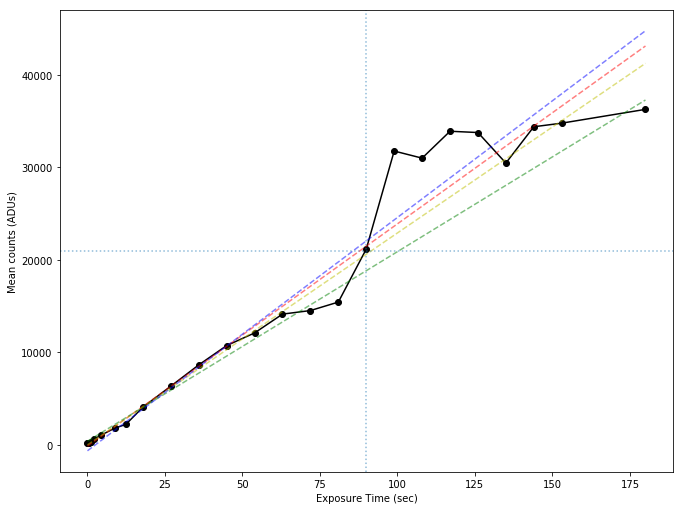

In [47]:
fig,ax = plt.subplots(1,1)                    
fig.set_size_inches(11,8.5)                   

ax.set_xlabel('Exposure Time (sec)')
ax.set_ylabel('Mean counts (ADUs)')
# ax[1].set_ylabel('Mean counts (electrons)')
# ax[1].set_xlabel('Exposure Time (sec)')


ax.plot(exp_times, mean_ADUs, '-ko')
# ax[1].plot(exp_times, mean_electrons, '-ko')


ax.plot(exp_times,linfity0,color='r',linestyle='dashed',alpha=.50)
ax.plot(exp_times,linfity1,color='y',linestyle='dashed',alpha=.50)
ax.plot(exp_times,linfity2,color='g',linestyle='dashed',alpha=.50)
ax.plot(exp_times,linfity3,color='b',linestyle='dashed',alpha=.50)

ax.axvline(90,linestyle=":",alpha=.50)
ax.axhline(21000,linestyle=":",alpha=.50)
# ax.axhline(ADU_sat,linestyle=":",alpha=.50)

# ax[1].axvline(85,linestyle=":",alpha=.50)
# ax[1].axhline(ADU_sat_in_e,linestyle=":",alpha=.50);

Sub Image (regions) analysis:

In [48]:
row0 = 100
row1 = 200
colm0 = 200
colm1 = 300

subf1=flat1[row0:row1, colm0:colm1]
subf2=flat2[row0:row1, colm0:colm1]
subb1=bias1[row0:row1, colm0:colm1]
subb2=bias2[row0:row1, colm0:colm1]

print('For these flats, the gain is {0:.4f} electrons/ADUs and the read noise is {1:.4f} ADUs, or {2:.4f} electrons.'.format(calculate_gain(subf1,subf2,subb1,subb2),calculate_noise(subf1,subf2,subb1,subb2),calculate_noise_in_electrons(subf1,subf2,subb1,subb2)))

For these flats, the gain is 0.4290 electrons/ADUs and the read noise is 36.0733 ADUs, or 15.4745 electrons.


In [49]:
row0 = 200
row1 = 400
colm0 = 300
colm1 = 500

subf1=flat1[row0:row1, colm0:colm1]
subf2=flat2[row0:row1, colm0:colm1]
subb1=bias1[row0:row1, colm0:colm1]
subb2=bias2[row0:row1, colm0:colm1]

print('For these flats, the gain is {0:.4f} electrons/ADUs and the read noise is {1:.4f} ADUs, or {2:.4f} electrons.'.format(calculate_gain(subf1,subf2,subb1,subb2),calculate_noise(subf1,subf2,subb1,subb2),calculate_noise_in_electrons(subf1,subf2,subb1,subb2)))

For these flats, the gain is 0.4521 electrons/ADUs and the read noise is 36.2903 ADUs, or 16.4076 electrons.


In [51]:
#Making the bins for the regions to find and plot the gain in
row_bins = np.linspace(0, flat1.shape[0], 5).astype(int)
print(row_bins)
col_bins = np.linspace(0, flat1.shape[1], 10).astype(int)
print(col_bins)

[  0 123 247 371 495]
[  0  73 146 219 292 365 438 511 584 657]


In [52]:
gain_map = np.zeros((len(row_bins) - 1, len(col_bins - 1)))
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_slice = slice(row_bins[ii], row_bins[ii + 1])
        col_slice = slice(col_bins[jj], col_bins[jj + 1])
        
        local_gain = calculate_gain(flat1[row_slice, col_slice], flat2[row_slice, col_slice],
                                    bias1[row_slice, col_slice], bias2[row_slice, col_slice])
        
        gain_map[ii, jj] = local_gain

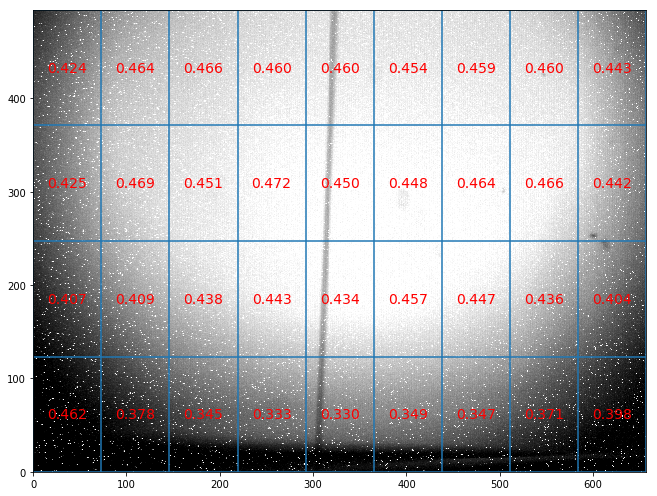

In [70]:
fig,ax = plt.subplots(1,1)                    
fig.set_size_inches(11,8.5)                   


ax.imshow(flat1, vmin=np.percentile(flat1, 5), vmax=np.percentile(flat1, 90),
           origin='lower', cmap='binary_r', interpolation='nearest')

for row in row_bins:
    ax.axhline(row)
for col in col_bins:
    ax.axvline(col)

for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_loc = (row_bins[ii] + row_bins[ii + 1]) / 2
        col_loc = (col_bins[jj] + col_bins[jj + 1]) / 2
        
        ax.text(col_loc, row_loc, '{:.3f}'.format(gain_map[ii, jj]),
                 ha='center', va='center', fontsize=14, color='r')

ax.set_xlim(0, col_bins[-1])
ax.set_ylim(0, row_bins[-1]);


Dark Current and Band Gap Energy analysis using given data:

In [72]:
t_cel = np.array([-15., -10., -8., -6., -4.2, -2.3, 0., 2., 
                3.6, 5.8, 8.2, 10., 12.8, 16.2, 20.])
adu = np.array([13, 15, 16, 17, 19, 22, 24, 28, 32, 37, 
                43, 50, 62, 89, 139])
exptime=120
adu_per_sec=adu/exptime
t_kel = t_cel + 273.15
invt=1/t_kel
electrons = 2.3*adu
electrons_per_sec = electrons/exptime
k_b = 8.6175e-5

Defining function for dark current, using above variables:

In [73]:
def dark_current(t_kel, alpha, e_g):
    dark_current = alpha * np.exp(-e_g / (2 * k_b * t_kel))
    return dark_current

In [74]:
t_0 = t_kel[-1]
d_0 = electrons_per_sec[-1]

alpha_0 =  d_0 / np.exp(-1.1 / (2 * k_b * t_0))
e_g_0 = 1.1
p_opt, p_cov = curve_fit(dark_current, t_kel, electrons_per_sec, p0=[alpha_0, e_g_0])

sig_alpha, sig_e_g = np.sqrt(np.diag(p_cov))
alpha_fit, e_g_fit = p_opt

dark_current_ADU=dark_current(t_kel,alpha_fit,e_g_fit)/2.3
d_el=dark_current(273.15,alpha_fit,e_g_fit)
d_adu=d_el/2.3

print("The best fit constant is {0:.2f} eV.".format(alpha_fit))
print("The best fit band gap energy is {0:.2f} eV.".format(e_g_fit))
print("The dark current at 273.15 Kelvin is {0:.2f} electrons/pixel/sec or {1:0.2f} ADUs/pixel/sec.".format(d_el,d_adu))


The best fit constant is 77098910165.43 eV.
The best fit band gap energy is 1.22 eV.
The dark current at 273.15 Kelvin is 0.42 electrons/pixel/sec or 0.18 ADUs/pixel/sec.


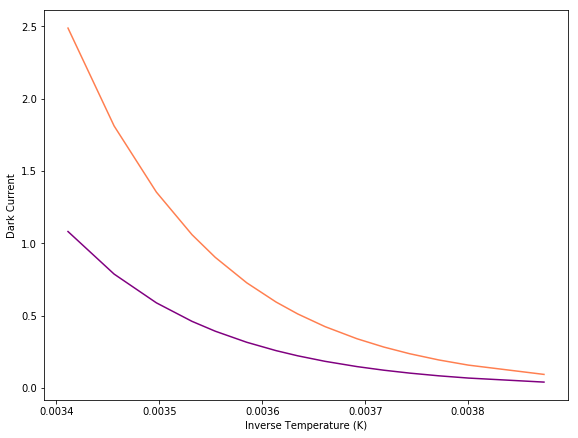

In [75]:
fig, ax = plt.subplots(1,1)             
fig.set_size_inches(8,6)                   
fig.tight_layout() 

ax.set_xlabel('Inverse Temperature (K)')
ax.set_ylabel('Dark Current')

ax.plot(invt,dark_current(t_kel, alpha_fit, e_g_fit),color='coral')
ax.plot(invt,dark_current_ADU,color="purple")


Using the "good" dataset given in class

In [76]:
xflat_list=glob.glob('/Users/anikaslizewski/Lab-Journal/ccddata/Xavier/[0-9]*.FIT')
xflat1 = fits.getdata('/Users/anikaslizewski/Lab-Journal/ccddata/Xavier/18_sec.FIT').astype(np.int32)
xflat2 = fits.getdata('/Users/anikaslizewski/Lab-Journal/ccddata/Xavier/18_sec2.FIT').astype(np.int32)
xbias1 = fits.getdata('/Users/anikaslizewski/Lab-Journal/ccddata/Xavier/bias1.FIT').astype(np.int32)
xbias2 = fits.getdata('/Users/anikaslizewski/Lab-Journal/ccddata/Xavier/bias2.FIT').astype(np.int32) 

In [77]:
xexp_times = []
xmeans = []

for filename in xflat_list:
    xhdu = fits.open(filename)
    
    xexptime = xhdu[0].header['exptime']
    xexp_times.append(xexptime)
    
    xmean_counts = np.mean(xhdu[0].data)
    xmeans.append(xmean_counts)

xexp_times = np.array(xexp_times)
xmeans = np.array(xmeans)

xtime_sort = np.argsort(xexp_times)
xexp_times = xexp_times[xtime_sort]
xmeans = xmeans[xtime_sort]

In [78]:
xlinfitx0 = np.polyfit(xexp_times[1:7],xmeans[1:7],1)
xlinfity0 = np.polyval(xlinfitx0,xexp_times)

xlinfitx1 = np.polyfit(xexp_times[1:8],xmeans[1:8],1)
xlinfity1 = np.polyval(xlinfitx1,xexp_times)

xlinfitx2 = np.polyfit(xexp_times[1:9],xmeans[1:9],1)
xlinfity2 = np.polyval(xlinfitx2,xexp_times)

xlinfitx3 = np.polyfit(xexp_times[1:10],xmeans[1:10],1)
xlinfity3 = np.polyval(xlinfitx3,xexp_times)


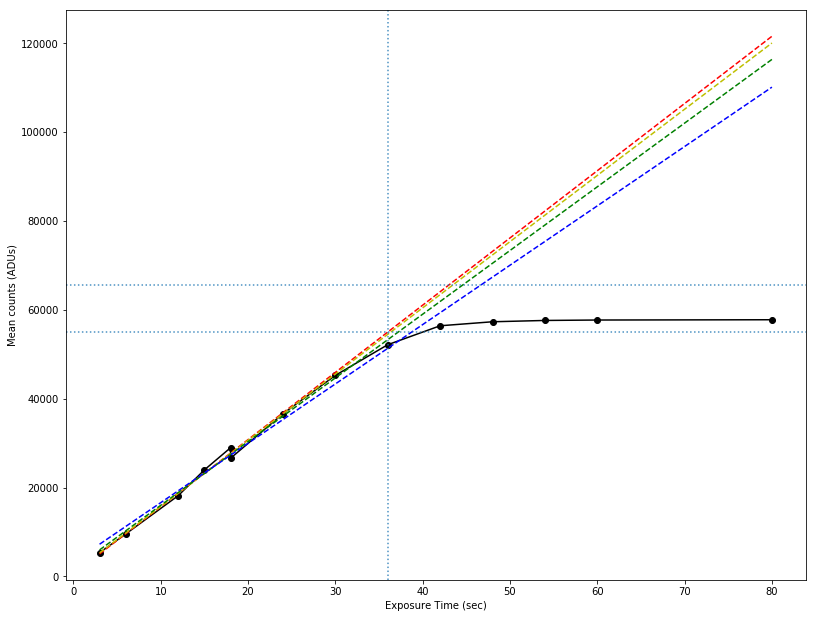

In [79]:
fig,ax = plt.subplots(1,1)                    
fig.set_size_inches(11,8.5)                   
fig.tight_layout() 

ax.set_xlabel('Exposure Time (sec)')
ax.set_ylabel('Mean counts (ADUs)')

ax.plot(xexp_times, xmeans, '-ko')

ax.plot(xexp_times,xlinfity0,color='r',linestyle='dashed')

ax.plot(xexp_times,xlinfity1,color='y',linestyle='dashed')

ax.plot(xexp_times,xlinfity2,color='g',linestyle='dashed')

ax.plot(xexp_times,xlinfity3,color='b',linestyle='dashed')

ax.axvline(36,linestyle=":",alpha=50)
ax.axhline(ADU_sat,linestyle=":",alpha=50)
ax.axhline(55000,linestyle=":",alpha=50);

In [80]:
print('For these flats and biases, the gain is {0:.4f} electrons/ADUs and the read noise is {1:.4f} ADUs, or {2:.4f} electrons.'.format(calculate_gain(xflat1,xflat2,xbias1,xbias2),calculate_noise(xflat1,xflat2,xbias1,xbias2),calculate_noise_in_electrons(xflat1,xflat2,xbias1,xbias2)))

For these flats and biases, the gain is 0.7447 electrons/ADUs and the read noise is 13.7108 ADUs, or 10.2106 electrons.
